In [47]:
import random
import json
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Player.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Street.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Utility.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Station.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Chance.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Tax.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Go.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Jail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\FreeParking.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\GoToJail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\CommunityChest.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\MonopolyBoard.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Strategy.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\RandomStrategy.py"

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MonopolyBoardMCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\Node.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\State.py"

## Running Grid Search

In [48]:
def game(max_iterations, exploration_weight, max_simulations, max_rounds):
    # create board and add players
    board = MonopolyBoardMCTS()
    player1 = Player('Cat')
    player2 = Player('Vlad')
    board.add_agent(player1)
    board.add_other_player(player2)

    # using a random strategy
    strategy = RandomStrategy()
    board.strategy = strategy

    # run MCTS game
    root_state = State()
    root_state.from_monopoly_board(board)
    mcts = MCTS(root_state, max_iterations=max_iterations, exploration_weight=exploration_weight, max_simulations=max_simulations)
    mcts.run_game_quiet(max_rounds=max_rounds)

    return mcts.root.state

In [49]:
from tqdm import tqdm
def grid_search(max_iterations_lst, exploration_weight_lst, max_simulations_lst, max_rounds=20, num_tests=100):
    df = pd.DataFrame(columns=['max_iterations', 'exploration_weight', 'max_simulations', 
        'Rounds', 'Agent', 'Other player(s)', 'Properties', 'Stations', 'Utilities', 'Agent Wealth', 'Other Player(s) Wealth'])
        
    for max_iterations in max_iterations_lst:
        for exploration_weight in exploration_weight_lst:
            for max_simulations in max_simulations_lst:
                print(f'Currently testing max_iterations={max_iterations}, exploration_weight={exploration_weight}, max_simulations={max_simulations}')
                for _ in tqdm(range(num_tests)):
                    state = game(max_iterations, exploration_weight, max_simulations, max_rounds)
                    new_row = {'max_iterations': max_iterations, 'exploration_weight': exploration_weight, 
                        'max_simulations': max_simulations, 'Rounds': state.rounds, 'Agent': state.agent, 
                        'Other player(s)': state.other_players, 'Properties': state.properties, 'Stations': state.stations, 
                        'Utilities': state.utilities, 'Agent Wealth': state.agent_wealth, 
                        'Other Player(s) Wealth': state.other_players_wealth}
                    df.loc[len(df)] = new_row

    return df

In [50]:
random.seed(42)
max_iterations_lst = [50, 100, 250, 500, 1000]
exploration_weight_lst = [1, 1.41]
max_simulations_lst = [5, 10, 25, 50]
grid_search_df = grid_search(max_iterations_lst, exploration_weight_lst, max_simulations_lst)

Currently testing max_iterations=50, exploration_weight=1, max_simulations=5


  6%|▌         | 6/100 [00:10<02:49,  1.80s/it]

In [ ]:
file_path = 'GridSearch_RandomStrategy.json'
with open(file_path, 'w') as json_file:
    json.dump(grid_search_df.to_dict(), json_file, indent=4)

## Interpreting Grid Search Results

In [12]:
file_path = 'GridSearch_BaseStrategy.json'
with open(file_path, 'r') as json_file:
    results = json.load(json_file)

In [23]:
list(results['Agent Wealth'].values())[0]


1739.0

In [39]:
list(results['Agent'].values())[57][-1].values()

dict_values([100])

In [40]:
dict_results = {'Agent bankrupt': [0]*40, 'Other player(s) bankrupt': [0]*40, 'Agent greater wealth': [0]*40,
                'Other player(s) greater wealth': [0]*40, 'Tied': [0]*40}

for i in range(40):
    agent_bankrupt = 0
    player_bankrupt = 0
    agent_greater_wealth = 0
    player_greater_wealth = 0
    tied = 0
    for j in range(100):
        money_owed_player = sum(list(results['Agent'].values())[100*i+j][-1].values())
        money_owed_agent = sum(list(results['Other player(s)'].values())[100*i+j][0][-1].values())
        if list(results['Agent'].values())[100*i+j][3]:
            agent_bankrupt += 1
        elif list(results['Other player(s)'].values())[100*i+j][0][3]:
            player_bankrupt += 1
        elif list(results['Agent Wealth'].values())[100*i+j] - money_owed_agent\
            > list(results['Other Player(s) Wealth'].values())[100*i+j][0] - money_owed_player:
            agent_greater_wealth += 1
        elif list(results['Agent Wealth'].values())[100*i+j] - money_owed_agent\
            < list(results['Other Player(s) Wealth'].values())[100*i+j][0] - money_owed_player:
            player_greater_wealth += 1
        else:
            tied += 1

    dict_results['Agent bankrupt'][i] = agent_bankrupt
    dict_results['Other player(s) bankrupt'][i] = player_bankrupt
    dict_results['Agent greater wealth'][i] = agent_greater_wealth
    dict_results['Other player(s) greater wealth'][i] = player_greater_wealth
    dict_results['Tied'][i] = tied

<Axes: >

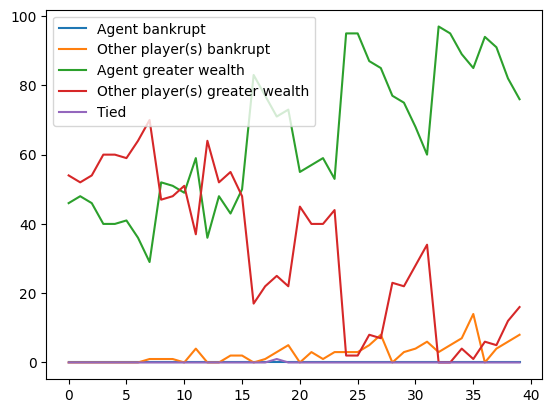

In [42]:
df_results = pd.DataFrame(dict_results)
df_results.plot(kind='line')


In [43]:
df_results

,Agent bankrupt,Other player(s) bankrupt,Agent greater wealth,Other player(s) greater wealth,Tied
0,0,0,46,54,0
1,0,0,48,52,0
2,0,0,46,54,0
3,0,0,40,60,0
4,0,0,40,60,0
5,0,0,41,59,0
6,0,0,36,64,0
7,0,1,29,70,0
8,0,1,52,47,0
9,0,1,51,48,0


In [26]:
print(agent_bankrupt, player_bankrupt, agent_greater_wealth, player_greater_wealth, tied)

0 8 76 16 0


In [15]:
curr_max_iterations = results['max_iterations'].values()[0]
curr_exploration_weight = results['exploration_weight'].values()[0]
curr_max_simulations = results['max_simulations'].values()[0]
n = len(results['max_iterations'].values())
x, y, z = 0, 0, 0

while curr_max_iterations == results['max_iterations'].values()[x] and \
    curr_exploration_weight == results['exploration_weight'].values()[y] and \
    curr_max_simulations == results['max_simulations'].values()[z] and \
    x < n and y < n and z < n:

    
    
    x += 1
    y += 1
    z += 1


KeyError: 0